In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from pybaseball import team_game_logs, schedule_and_record

Get Mets data from 2013-2023

In [25]:
# Get the Mets game logs for the last 10 years
years = list(range(2013, 2024))  # Adjust this range as needed
frames = []

for year in years:
    logs = schedule_and_record(year, "NYM")
    # Remove the "(1)" style suffixes from the "Date" column
    logs['Date'] = logs['Date'].str.replace(r' \(\d+\)$', '', regex=True)
    logs['Date'] = logs['Date'] + f", {year}"
    # Convert the "Date" column to datetime format
    logs['Date'] = pd.to_datetime(logs['Date'], format='%A, %b %d, %Y')
    frames.append(logs)

In [26]:
all_data = pd.concat(frames)

# Filter for home games
home_games = all_data[all_data['Home_Away'] == 'Home']

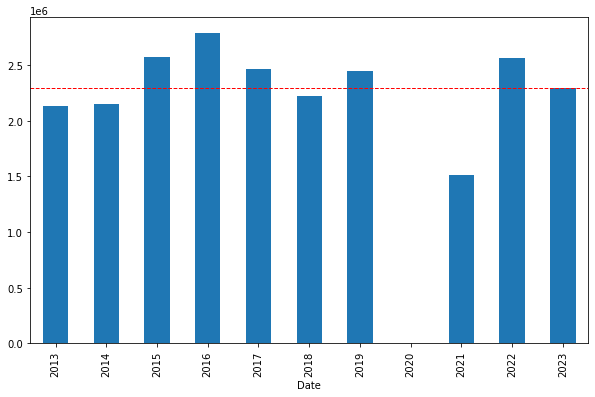

In [27]:
# Group by year and sum attendance
attendance_by_year = home_games.groupby(home_games['Date'].dt.year)['Attendance'].sum()

# Compute the average attendance
average_attendance = attendance_by_year.median()

# Plot
fig, ax = plt.subplots(figsize=(10,6))
attendance_by_year.plot(kind='bar', ax=ax)
ax.axhline(average_attendance, color='red', linestyle='dashed', linewidth=1)

<ipython-input-28-a30e80e30af5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_games['Year'] = home_games['Date'].dt.year
<ipython-input-28-a30e80e30af5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_games['Month'] = home_games['Date'].dt.month


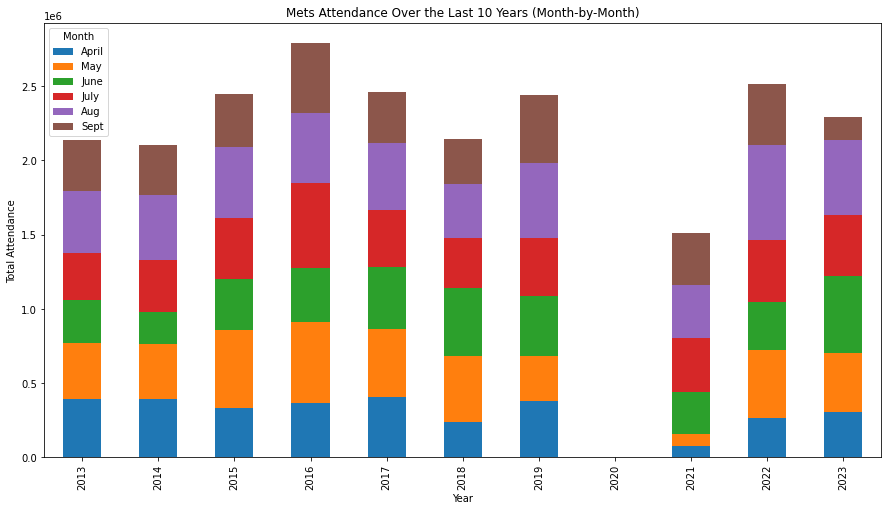

In [28]:
# Group by year and month, then sum attendance
home_games['Year'] = home_games['Date'].dt.year
home_games['Month'] = home_games['Date'].dt.month
home_games = home_games[home_games['Month'].isin([4, 5, 6, 7, 8, 9])]

attendance_by_month_year = home_games.groupby(['Year', 'Month'])['Attendance'].sum().unstack()

# Plot
attendance_by_month_year.plot(kind='bar', figsize=(15,8), stacked=True)
plt.title("Mets Attendance Over the Last 10 Years (Month-by-Month)")
plt.xlabel("Year")
plt.ylabel("Total Attendance")
plt.legend(title="Month", labels=['April', 'May', 'June', 'July', 'Aug', 'Sept'])
plt.show()

In [29]:
# Identify the best month for each year
attendance_by_month_year['Best Month'] = attendance_by_month_year.idxmax(axis=1)
attendance_by_month_year['Best Attendance'] = attendance_by_month_year.max(axis=1)

# Prepare a dictionary for month number to name conversion
month_map = {4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep'}
attendance_by_month_year['Best Month'] = attendance_by_month_year['Best Month'].replace(month_map)

# Display the best months and their attendance
best_months_table = attendance_by_month_year[['Best Month', 'Best Attendance']]

# Style the table
styled_table = best_months_table.style.bar(subset=['Best Attendance'], color='#d65f5f', align='left').format({
    'Best Attendance': "{:,.0f}"
}).set_properties(**{'text-align': 'left'}).set_caption("Best Months of Attendance Yearly")

styled_table

Month,Best Month,Best Attendance
Year,,
2013,Aug,"414,662"
2014,Aug,"441,538"
2015,May,"525,447"
2016,Jul,"574,784"
2017,May,"458,215"
2018,Jun,"458,861"
2019,Aug,"507,538"
2020,Jul,7
2021,Jul,"367,595"


In [31]:
# Best day of the week for attendance
best_day = home_games.groupby(home_games['Date'].dt.day_name())['Attendance'].mean().idxmax()
day_of_week_attendance = home_games.groupby(home_games['Date'].dt.day_name())['Attendance'].mean()

print(day_of_week_attendance)
print(f"The best day for attendance is: {best_day}")

# Opponents that bring in most attendance
opponent_attendance = home_games.groupby('Opp')['Attendance'].mean()
best_opponent = home_games.groupby('Opp')['Attendance'].mean().idxmax()

print(opponent_attendance)
print(f"The opponent that draws the most attendance is: {best_opponent}")

Date
Friday       31529.813008
Monday       26366.385714
Saturday     34077.679688
Sunday       31540.330709
Thursday     28101.383721
Tuesday      26370.364407
Wednesday    27095.495798
Name: Attendance, dtype: float64
The best day for attendance is: Saturday


In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

home_games = home_games.dropna(subset=["Attendance"])

# Assuming you have a DataFrame 'data' with relevant features including 'Attendance'.

# Feature selection - choose relevant features
selected_features = ['Month']

# Create a new DataFrame with selected features
X = home_games[selected_features]

# Target variable
y = home_games['Attendance']

# One-hot encode categorical variables (e.g., 'DayOfWeek' and 'Opponent')
X_encoded = pd.get_dummies(X, columns=['Month'], drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# You can also use the model to predict attendance for new data points
# new_data = pd.DataFrame({'DayOfWeek': ['Sunday'], 'Opponent': ['Opponent_X'], 'Weather': ['Sunny'], 'TeamPerformance': [0.75], 'Promotion': [1]})
# new_data_encoded = pd.get_dummies(new_data, columns=['DayOfWeek', 'Opponent'], drop_first=True)
# predicted_attendance = model.predict(new_data_encoded)


Mean Squared Error: 46581115.677333735
R-squared: 0.004769031469562757


In [52]:
y_test

98     43693.0
102    40035.0
67     43707.0
78     24506.0
79     35295.0
        ...   
133    38389.0
52     35123.0
22     44466.0
62     33268.0
127    35636.0
Name: Attendance, Length: 155, dtype: float64

In [53]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(y_test['Attendance'], label='Actual Attendance', marker='o')
plt.plot(y_pred[0], label='Predicted Attendance', marker='x')
plt.title('Actual vs Predicted Attendance')
plt.xlabel('Games')
plt.ylabel('Attendance')
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'Attendance'

<Figure size 720x432 with 0 Axes>